[View in Colaboratory](https://colab.research.google.com/github/dkanunnikov/netology/blob/master/dk_cv3.ipynb)

# Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. 

Задание засчитывается при значениях метрики Log Loss меньше 0.3.​

In [0]:
import warnings
#warnings.filterwarnings("ignore")
import numpy as np
import keras
from keras.models import Model
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import pandas as pd



In [200]:
!pip install kaggle-cli

In [0]:
!rm -rf ./train/ && rm -rf ./test/

In [202]:
!kg  download -u webotdel@mail.ru -p 64136413L  -c dogs-vs-cats-redux-kernels-edition -f train.zip

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip already downloaded !


In [203]:
!kg  download -u webotdel@mail.ru -p 64136413L  -c dogs-vs-cats-redux-kernels-edition -f test.zip

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

test.zip already downloaded !


In [0]:
!unzip -q train.zip && unzip -q test.zip

In [0]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

In [0]:
import re
from random import shuffle
from glob import glob

train_files = glob('./train/*.jpg')
test_files = glob('./test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

# **Визуализируем примеры для обучения**

In [0]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

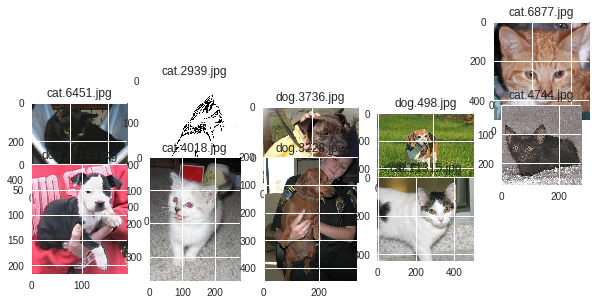

In [208]:
fig = plt.figure(figsize=(10, 5))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

### Будем использовать Xception

In [0]:
base_model = Xception(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [210]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### Добавляем полносвязный слой и замораживаем остальные.

In [0]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [214]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [215]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 50  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=5,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/5
10/10 [==============================] - 14s 1s/step - loss: 0.2056 - acc: 0.8875 - val_loss: 0.0939 - val_acc: 0.9600
Epoch 2/5
10/10 [==============================] - 8s 760ms/step - loss: 0.0520 - acc: 0.9812 - val_loss: 0.0416 - val_acc: 0.9800
Epoch 3/5
10/10 [==============================] - 8s 758ms/step - loss: 0.0918 - acc: 0.9688 - val_loss: 0.0756 - val_acc: 0.9600
Epoch 4/5
10/10 [==============================] - 8s 762ms/step - loss: 0.1170 - acc: 0.9500 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 5/5
10/10 [==============================] - 8s 761ms/step - loss: 0.0511 - acc: 0.9781 - val_loss: 0.0122 - val_acc: 1.0000


In [0]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500, verbose = 1)

 4006/12500 [========>.....................] - ETA: 6:10

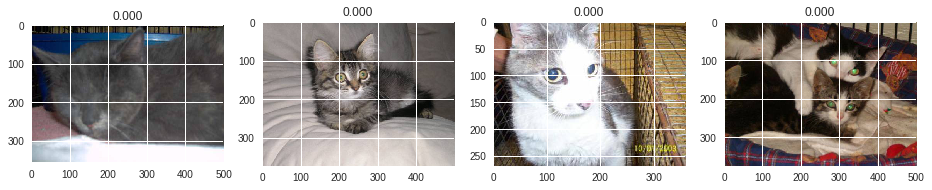

In [191]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[:4], pred[:4]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

### Попробуем немного затюнить. Выводим все слои и замораживаем все, кроме последних двух блоков

In [192]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)


0 input_6
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_21
13 block2_pool
14 batch_normalization_21
15 add_61
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_22
23 block3_pool
24 batch_normalization_22
25 add_62
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_23
33 block4_pool
34 batch_normalization_23
35 add_63
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_64
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 blo

In [0]:
for layer in model.layers[:115]:
   layer.trainable = False
for layer in model.layers[115:]:
   layer.trainable = True

#### Компилируем модель

In [0]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy')

In [195]:
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 15s 2s/step - loss: 0.0415 - val_loss: 0.0040
Epoch 2/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0953 - val_loss: 0.0072
Epoch 3/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0895 - val_loss: 0.0078
Epoch 4/100
10/10 [==============================] - 9s 884ms/step - loss: 0.1156 - val_loss: 0.0077
Epoch 5/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0941 - val_loss: 0.0054
Epoch 6/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0592 - val_loss: 0.0051
Epoch 7/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0508 - val_loss: 0.0051
Epoch 8/100
10/10 [==============================] - 9s 886ms/step - loss: 0.1481 - val_loss: 0.0054
Epoch 9/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0921 - val_loss: 0.0053
Epoch 10/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0449 - val_loss

10/10 [==============================] - 9s 883ms/step - loss: 0.0196 - val_loss: 0.0040
Epoch 15/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0728 - val_loss: 0.0040
Epoch 16/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0580 - val_loss: 0.0040
Epoch 17/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0786 - val_loss: 0.0037
Epoch 18/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0338 - val_loss: 0.0035
Epoch 19/100
10/10 [==============================] - 9s 883ms/step - loss: 0.1612 - val_loss: 0.0036
Epoch 20/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0594 - val_loss: 0.0035
Epoch 21/100
10/10 [==============================] - 9s 886ms/step - loss: 0.0513 - val_loss: 0.0035
Epoch 22/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0788 - val_loss: 0.0035
Epoch 23/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0486 - val_loss: 

10/10 [==============================] - 9s 888ms/step - loss: 0.0947 - val_loss: 0.0036
Epoch 28/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0343 - val_loss: 0.0036
Epoch 29/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0347 - val_loss: 0.0036
Epoch 30/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0714 - val_loss: 0.0036
Epoch 31/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0195 - val_loss: 0.0036
Epoch 32/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0463 - val_loss: 0.0037
Epoch 33/100
10/10 [==============================] - 9s 883ms/step - loss: 0.1329 - val_loss: 0.0036
Epoch 34/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0390 - val_loss: 0.0036
Epoch 35/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0614 - val_loss: 0.0036
Epoch 36/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0510 - val_loss: 

10/10 [==============================] - 9s 884ms/step - loss: 0.0471 - val_loss: 0.0037
Epoch 41/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0445 - val_loss: 0.0037
Epoch 42/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0254 - val_loss: 0.0037
Epoch 43/100
10/10 [==============================] - 9s 887ms/step - loss: 0.0502 - val_loss: 0.0037
Epoch 44/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0369 - val_loss: 0.0037
Epoch 45/100
10/10 [==============================] - 9s 888ms/step - loss: 0.0760 - val_loss: 0.0038
Epoch 46/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0800 - val_loss: 0.0038
Epoch 47/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0584 - val_loss: 0.0038
Epoch 48/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0439 - val_loss: 0.0038
Epoch 49/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0654 - val_loss: 

10/10 [==============================] - 9s 883ms/step - loss: 0.0796 - val_loss: 0.0039
Epoch 54/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0795 - val_loss: 0.0039
Epoch 55/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0267 - val_loss: 0.0039
Epoch 56/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0337 - val_loss: 0.0039
Epoch 57/100
10/10 [==============================] - 9s 886ms/step - loss: 0.0232 - val_loss: 0.0038
Epoch 58/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0635 - val_loss: 0.0037
Epoch 59/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0577 - val_loss: 0.0038
Epoch 60/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0261 - val_loss: 0.0038
Epoch 61/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0232 - val_loss: 0.0038
Epoch 62/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0259 - val_loss: 

10/10 [==============================] - 9s 884ms/step - loss: 0.0525 - val_loss: 0.0038
Epoch 67/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0789 - val_loss: 0.0038
Epoch 68/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0448 - val_loss: 0.0039
Epoch 69/100
10/10 [==============================] - 9s 886ms/step - loss: 0.0247 - val_loss: 0.0039
Epoch 70/100
10/10 [==============================] - 9s 881ms/step - loss: 0.0411 - val_loss: 0.0040
Epoch 71/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0247 - val_loss: 0.0040
Epoch 72/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0678 - val_loss: 0.0040
Epoch 73/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0535 - val_loss: 0.0041
Epoch 74/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0669 - val_loss: 0.0041
Epoch 75/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0261 - val_loss: 

10/10 [==============================] - 9s 884ms/step - loss: 0.0691 - val_loss: 0.0041
Epoch 80/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0121 - val_loss: 0.0041
Epoch 81/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0555 - val_loss: 0.0040
Epoch 82/100
10/10 [==============================] - 9s 888ms/step - loss: 0.0431 - val_loss: 0.0039
Epoch 83/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0421 - val_loss: 0.0039
Epoch 84/100
10/10 [==============================] - 9s 885ms/step - loss: 0.0388 - val_loss: 0.0039
Epoch 85/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0485 - val_loss: 0.0039
Epoch 86/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0256 - val_loss: 0.0040
Epoch 87/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0328 - val_loss: 0.0039
Epoch 88/100
10/10 [==============================] - 9s 887ms/step - loss: 0.0677 - val_loss: 

10/10 [==============================] - 9s 882ms/step - loss: 0.0423 - val_loss: 0.0040
Epoch 93/100
10/10 [==============================] - 9s 881ms/step - loss: 0.0232 - val_loss: 0.0041
Epoch 94/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0219 - val_loss: 0.0040
Epoch 95/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0151 - val_loss: 0.0040
Epoch 96/100
10/10 [==============================] - 9s 882ms/step - loss: 0.0818 - val_loss: 0.0040
Epoch 97/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0381 - val_loss: 0.0041
Epoch 98/100
10/10 [==============================] - 9s 884ms/step - loss: 0.0402 - val_loss: 0.0041
Epoch 99/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0233 - val_loss: 0.0041
Epoch 100/100
10/10 [==============================] - 9s 883ms/step - loss: 0.0509 - val_loss: 0.0041


In [196]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500, verbose = 1)

12500/12500 [==============================] - 540s 43ms/step


In [0]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [0]:
files.download('submit.txt')

## Score в Kaggle = 0.05564